
References: 
1. http://ipywidgets.readthedocs.io/en/latest/examples/Lorenz%20Differential%20Equations.html
2. https://github.com/mspieg/dynamical-systems/blob/master/LorenzEquations.ipynb
3. https://en.wikipedia.org/wiki/List_of_dynamical_systems_and_differential_equations_topics
4. http://ipython-books.github.io/chapter-12-deterministic-dynamical-systems/
http://ipython-books.github.io/
5. http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/
6. http://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/
7. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
8. http://www.iro.umontreal.ca/~lisa/pointeurs/RazvanPascanuThesis.pdf (also in downloads)
9. https://www.gribblelab.org/compneuro/2_Modelling_Dynamical_Systems.html#orgheadline5 
10. https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f
11. https://github.com/yuqirose/trnn poster - http://roseyu.com/Materials/nips17-tsw-poster.pdf
12. https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [1]:
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

In [2]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Generate Time Series using the Lorenz System of DE

In [5]:

def solve_lorenz(N=10, angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')
    SEQUENCE_SIZE = 100         # length of the sequence to generate
    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))

    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])

    # choose a different color for each trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
       # print(x, y, z) #print the data
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)
    plt.show()
    return t, x_t

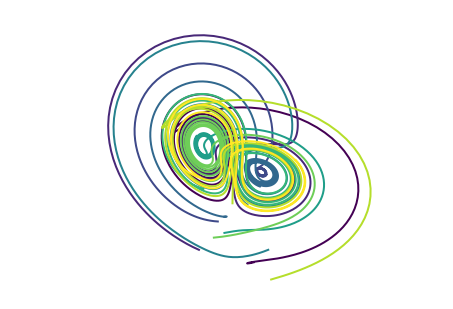

In [6]:
t, x_t = solve_lorenz(angle=0, N=10) #angle initially at 0, butterfly at 134

In [7]:

widget = interactive(solve_lorenz, angle=(0.,360.), max_time=(0.1, 4.0),
                N=(0,50), sigma=(0.0,50.0), rho=(0.0,50.0))
display(widget)

A Jupyter Widget

In [8]:
t, x_t = widget.result

In [9]:
#print(x_t)

In [10]:
widget.kwargs

{'N': 10,
 'angle': 0.0,
 'beta': 2.6666666666666665,
 'max_time': 4.0,
 'rho': 28.0,
 'sigma': 10.0}

In [11]:
xyz_avg = x_t.mean(axis=1)

In [12]:
xyz_avg.shape

(10, 3)

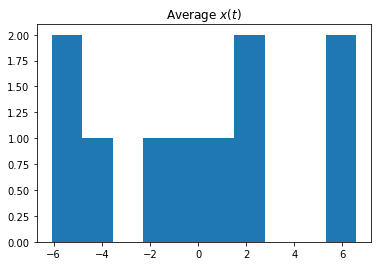

In [13]:
plt.hist(xyz_avg[:,0])
plt.title('Average $x(t)$');

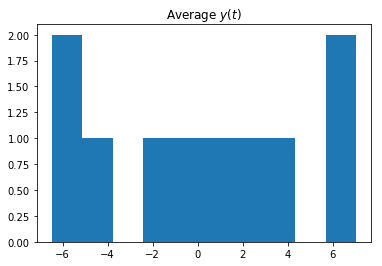

In [40]:
plt.hist(xyz_avg[:,1])
plt.title('Average $y(t)$');

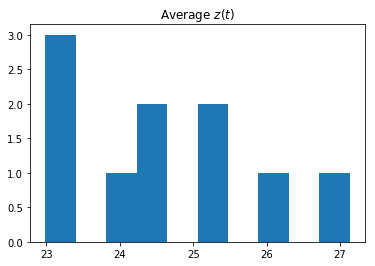

In [41]:
plt.hist(xyz_avg[:,2])
plt.title('Average $z(t)$');

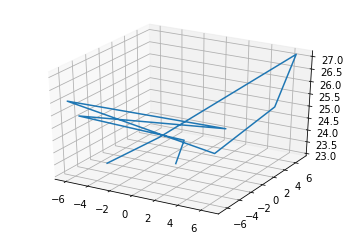

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xyz_avg[:,0], xyz_avg[:,1], xyz_avg[:,2])
plt.show()

## Convert data into format for Keras

In [16]:
# split into train and test sets
train_size = int(len(x_t)* 0.70)
print(train_size)
test_size = len(x_t) - train_size
lorenz_train = x_t[0:train_size]
lorenz_test  = x_t[train_size:len(x_t)]
print ("train shape : " , lorenz_train.shape)
print ("test shape : " , lorenz_test.shape)

7
train shape :  (7, 1000, 3)
test shape :  (3, 1000, 3)


In [17]:

def to_sequences(seq_size, obs): 
    x = []
    y = []
    for i in range(len(obs)-SEQUENCE_SIZE-1):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
    return np.array(x),np.array(y)

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
SEQUENCE_SIZE = 10
x_train, y_train = to_sequences(SEQUENCE_SIZE,lorenz_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,lorenz_test)
print("Shape of training set: {}".format(lorenz_train.shape))
print("Shape of test set: {}".format(lorenz_test.shape))

Shape of training set: (7, 1000, 3)
Shape of test set: (3, 1000, 3)


## Build Neural Network model in Keras

In [39]:
print('Build model...')
model = Sequential()
model.add(LSTM(16, batch_input_shape=(None, None, 3))) #https://faroit.github.io/keras-docs/1.0.1/getting-started/sequential-model-guide/
#model.add(Flatten())
#model.add(Dense(6))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')

#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

Build model...
Train...


In [34]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=1000)

ValueError: Error when checking target: expected dense_11 to have shape (3,) but got array with shape (1,)

## Plot original values and predictions

   '''
    plt.plot(x, y, z, '-')
    #plt.ylabel('some numbers')
    plt.xlabel('Logistics')
    plt.show()
   ''' 

## Calculate difference between prediction and actual